# BOSTON MARATHON PROJECT 

# I. Introduction

The data describes the Boston Marathon results in 2014

The project is about unsupervised learning and applying K-means algorithm

# II. Data description 

The data is available from baa.org.

https://github.com/llimllib/bostonmarathon

# III. Content 

In [1]:
import pandas as pd

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')


In [4]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


# 1.Data exploration

### There are some features that contains ' - ' value

In [6]:
(df == '-').sum()

10k          0
name         0
division     0
25k          0
gender       0
age          0
official     0
bib          0
genderdiv    0
ctz          0
35k          0
overall      0
pace         0
state        0
30k          0
5k           0
half         0
20k          0
country      0
city         0
40k          0
dtype: int64

### all ' - ' values will be considered as missing values 

In [5]:
df = df.replace('-', np.NaN)

In [ ]:
(df == '-').sum()

### total missing values in conjunction with replaced ' - ' values 

In [7]:
types = df.dtypes.to_frame().rename(columns={0:'dtypes'})
null = df.isnull().sum().to_frame().rename(columns={0:'missing values'})
null_percent = (df.isnull().sum()/df.shape[0]*100).to_frame().rename(columns={0:'% missing values'})
df_missing = pd.concat([types, null, null_percent], axis=1)
df_missing

,dtypes,missing values,% missing values
10k,object,50,0.156328
name,object,0,0.000000
division,int64,0,0.000000
25k,object,216,0.675338
gender,object,0,0.000000
age,int64,0,0.000000
official,float64,0,0.000000
bib,object,0,0.000000
genderdiv,int64,0,0.000000
ctz,object,30740,96.110555


=> remove 'ctz' columns (96% missing values)

=> remove all other missing values (<10% missing values in each feature)

###  '10k','25k','35k','30k','5k','half','20k','40k' are 'Objects'. Convert them into 'float'

In [8]:
df[['10k','25k','35k','30k','5k','half','20k','40k']] = df[['10k','25k','35k','30k','5k','half','20k','40k']].astype('float64')

### 7 categorical features 

In [9]:
df.select_dtypes(object)

,name,gender,bib,ctz,state,country,city
0,"Yamamoto, Hiroyuki",M,W1,NaN,NaN,JPN,Fukuoka
1,"Jeptoo, Rita",F,F1,NaN,NaN,KEN,Eldoret
2,"Van Dyk, Ernst F.",M,W2,NaN,NaN,RSA,Paarl
3,"Dibaba, Mare",F,F2,NaN,NaN,ETH,Shoa
4,"Hokinoue, Kota",M,W3,NaN,NaN,JPN,Nogata Fukuoka
...,...,...,...,...,...,...,...
31979,"Anderson, Steve K.",M,35908,NaN,CA,USA,Larkspur
31980,"McCarthy, Michael P.",M,35909,NaN,MA,USA,Norwell
31981,"Brimmer, Delia C.",F,35910,NaN,CT,USA,West Simsbury
31982,"Morganthal, Amy",F,35911,NaN,MA,USA,North Andover


### 14 numeric features

In [10]:
df.select_dtypes(np.number)

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31979,50.72,3414,124.02,32,211.75,7500,174.90,9849,8.08,148.65,26.13,104.78,99.55,200.22
31980,61.28,5212,165.02,34,302.52,15459,244.70,27456,11.55,203.43,31.07,135.85,128.37,285.47
31981,59.00,5231,157.02,21,282.00,10788,229.62,25092,10.77,192.65,28.18,130.57,123.33,266.30
31982,63.75,5800,167.82,38,302.73,12009,247.18,27476,11.55,207.52,30.98,137.03,129.90,285.87


### remove all missing values

In [11]:
df1 = df.drop(columns='ctz')
df1 = df1.dropna().reset_index(drop=True)

# 2. Feature selection 

### 'name' , 'bib', 'city' features have too many distant values => remove them

In [12]:
df1.describe(include='O')

,name,gender,bib,state,country,city
count,29103,29103,29103,29103,29103,29103
unique,29044,2,29103,68,2,4648
top,"Johnson, Nancy",M,29088,MA,USA,Boston
freq,2,15578,1,7427,26939,1018


In [13]:
df2 = df1.drop(columns=['name','bib','city'])
df2

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,40k
0,30.48,20,77.68,M,31,137.83,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,129.83
1,17.12,13,48.88,M,29,87.40,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,82.38
2,33.93,10,85.03,F,30,143.90,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,136.47
3,18.30,14,50.33,M,47,89.40,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,84.48
4,18.78,15,50.33,M,30,89.52,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,84.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29098,50.72,3414,124.02,M,32,211.75,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,200.22
29099,61.28,5212,165.02,M,34,302.52,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,285.47
29100,59.00,5231,157.02,F,21,282.00,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,266.30
29101,63.75,5800,167.82,F,38,302.73,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,285.87


### correlation between features 

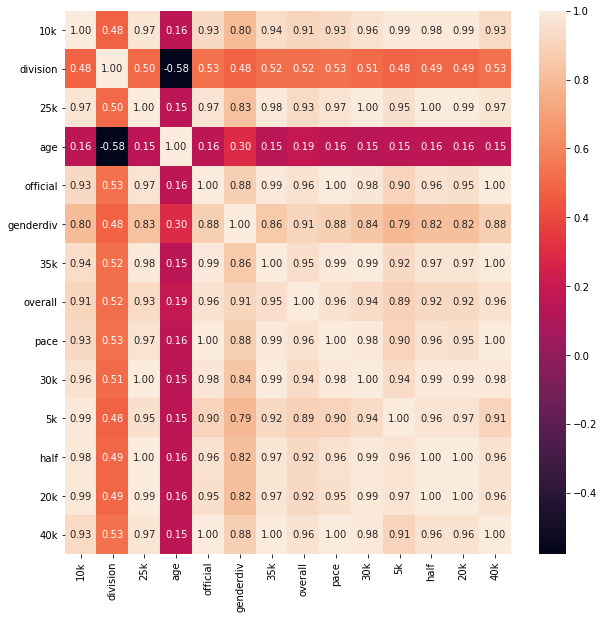

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(df2.select_dtypes(np.number).corr(), annot=True, fmt=".2f")
plt.show()

# 3. Data preprocessing

###  for numeric features, use StandardScaler and for categorical features, use LabelEncoder

In [26]:
num_feature = df2.select_dtypes(np.number)
cat_feature = df2.select_dtypes(object)

from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler().fit_transform(num_feature) 

#Standard Scaler
scaled_num = pd.DataFrame(scaler, columns=num_feature.columns)

#Label Encoder
scaled_cat = cat_feature.apply(LabelEncoder().fit_transform)

### features after scaling

In [31]:
new_feature = pd.concat([scaled_num,scaled_cat], axis=1)
new_feature

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender,state,country
0,-2.452515,-1.123988,-2.201826,-0.974107,-2.061701,-1.687681,-2.067632,-1.740609,-2.059235,-2.115770,-2.526599,-2.282455,-2.290687,-2.059789,1,9,1
1,-3.987414,-1.128029,-3.325624,-1.150348,-3.052062,-1.689160,-3.032671,-1.741373,-3.047840,-3.145967,-4.221417,-3.513440,-3.529102,-3.044965,1,48,0
2,-2.056153,-1.129761,-1.915024,-1.062227,-1.942496,-1.689794,-1.886320,-1.737774,-1.940808,-1.884612,-2.105866,-1.965242,-1.970658,-1.921926,0,29,1
3,-3.851846,-1.127452,-3.269044,0.435822,-3.012786,-1.688949,-2.980798,-1.741264,-3.011797,-3.100160,-4.066911,-3.434751,-3.445186,-3.001364,1,53,0
4,-3.796700,-1.126874,-3.269044,-1.062227,-3.010429,-1.688737,-2.979085,-1.741155,-3.011797,-3.088329,-3.993223,-3.433768,-3.444144,-2.995758,1,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29098,-0.127190,0.835401,-0.393605,-0.885986,-0.610034,-0.107413,-0.535168,-0.668714,-0.612371,-0.481591,0.083373,-0.337372,-0.322043,-0.598323,1,9,1
29099,1.086023,1.873404,1.206246,-0.709745,1.172538,1.574051,1.172735,1.251407,1.174326,1.180193,1.257623,1.190661,1.180109,1.171672,1,25,1
29100,0.824079,1.884372,0.894080,-1.855312,0.769559,0.587229,0.803749,0.993602,0.772705,0.853176,0.570663,0.930989,0.917415,0.773657,0,11,1
29101,1.369795,2.212862,1.315504,-0.357263,1.176662,0.845184,1.233417,1.253588,1.174326,1.304266,1.236230,1.248694,1.259856,1.179977,0,25,1


# 4. Model training 

## 4.1 without dropping high correlation features 

### choose optimal k number of clusters: k=4 

[8665829.682232054, 2270176.2248779526, 1229231.475224957, 745155.6252541027, 596081.8988219743, 489554.23597619776, 433119.99953876913, 399624.1381397508, 364680.56187576667]


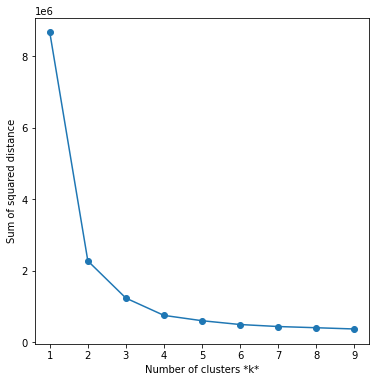

In [32]:
sse = []
K = list(range(1, 10))

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature)
    sse.append(kmeans.inertia_)

# Plot sse against k#
print(sse)
plt.figure(figsize=(6, 6))
plt.plot(K, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

In [33]:
km_not_drop = KMeans(n_clusters=4)
km_not_drop.fit(new_feature)
km_not_drop.inertia_

745156.1452109051

## 4.2 dropping high correlated features 

[8374799.682232035, 1989732.4000049909, 959238.2532599038, 474921.5635339085, 330075.85891827755, 271412.50088223524, 237220.2450841623, 205212.65101442597, 180572.7501293345]


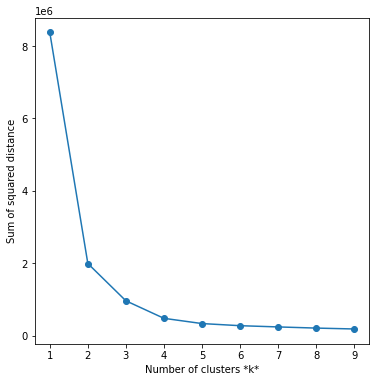

In [34]:
drop_new_feature = new_feature.drop(columns=['25k','5k','10k','35k','overall','pace','30k','half','20k','40k'])

sse = []
K = list(range(1, 10))

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(drop_new_feature)
    sse.append(kmeans.inertia_)

# Plot sse against k
print(sse)
plt.figure(figsize=(6, 6))
plt.plot(K, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

plt.show()

In [35]:
km_drop = KMeans(n_clusters=4)
km_drop.fit(new_feature)
km_drop.inertia_

745161.7204385692

### => the SSE at clusters = 4 of both dropping and not dropping correlated features are not different 

In [36]:
cluster = km_not_drop.labels_
cluster1 = km_drop.labels_

### get the clusters (0,1,2,3) class for each runners

In [37]:
df3 = df2.copy()
df3['cluster'] = cluster
df3

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,40k,cluster
0,30.48,20,77.68,M,31,137.83,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,129.83,2
1,17.12,13,48.88,M,29,87.40,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,82.38,3
2,33.93,10,85.03,F,30,143.90,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,136.47,1
3,18.30,14,50.33,M,47,89.40,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,84.48,0
4,18.78,15,50.33,M,30,89.52,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,84.75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29098,50.72,3414,124.02,M,32,211.75,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,200.22,2
29099,61.28,5212,165.02,M,34,302.52,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,285.47,1
29100,59.00,5231,157.02,F,21,282.00,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,266.30,2
29101,63.75,5800,167.82,F,38,302.73,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,285.87,1


# 6. Clustering and analyzing

### split the data based on cluster label

In [38]:
c0 = df3[df3.cluster == 0]
c1 = df3[df3.cluster == 1]
c2 = df3[df3.cluster == 2]
c3 = df3[df3.cluster == 3]

### cluster 0 has the most runners 

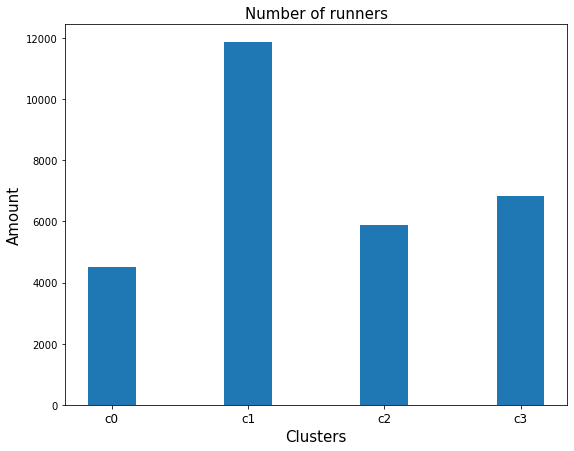

In [39]:
plt.figure(figsize=(9,7))
plt.bar([0,1,2,3], [c0.shape[0],c1.shape[0],c2.shape[0],c3.shape[0]], width=0.35)
plt.xticks([0,1,2,3], ['c0','c1','c2','c3'], fontsize=12)

plt.xlabel('Clusters', fontsize=15)
plt.ylabel('Amount', fontsize=15)
plt.title('Number of runners', fontsize=15)

plt.show()

## 6.1 Gender

###  Number of males and females in each clusters

In [40]:
cluster_gender = pd.concat((c0.gender.value_counts(),c1.gender.value_counts(),c2.gender.value_counts(),c3.gender.value_counts()), axis=1, keys=['c0','c1','c2','c3'])
cluster_gender

,c0,c1,c2,c3
M,2523,6077,3147,3831
F,2002,5781,2742,3000


### amount

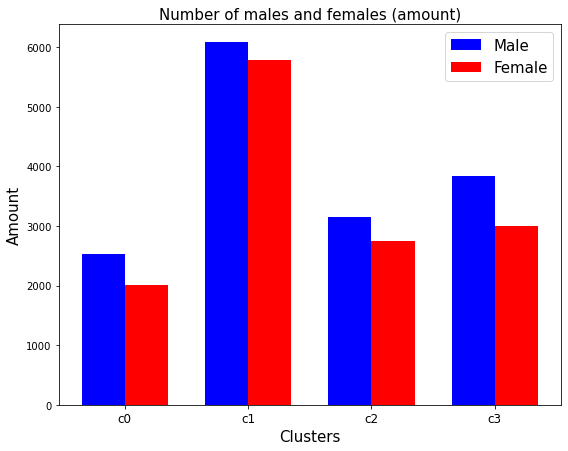

In [41]:
plt.figure(figsize=(9,7))
M = cluster_gender.loc['M']
F = cluster_gender.loc['F']
idx = np.arange(4)
bar_width = 0.35

plt.bar(idx - bar_width/2, M, color='b', width=bar_width, label='Male')
plt.bar(idx + bar_width/2, F, color='r', width=bar_width, label='Female')

plt.xticks(idx, cluster_gender.columns, fontsize=12)
plt.legend(fontsize=15)
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('Amount', fontsize=15)
plt.title('Number of males and females (amount)', fontsize=15)

plt.show()

### percentage 

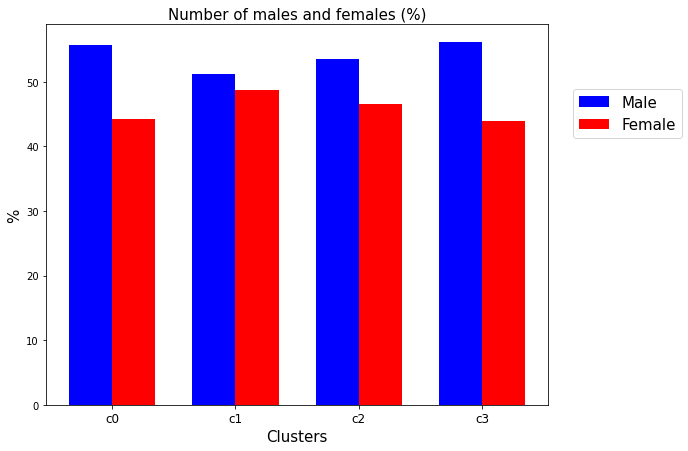

In [42]:
plt.figure(figsize=(9,7))
M_percent = cluster_gender.apply(lambda x: x.loc['M']/(x.loc['M']+x.loc['F'])*100)
F_percent = cluster_gender.apply(lambda x: x.loc['F']/(x.loc['M']+x.loc['F'])*100)
idx = np.arange(4)
bar_width = 0.35

plt.bar(idx - bar_width/2, M_percent, color='b', width=bar_width, label='Male')
plt.bar(idx + bar_width/2, F_percent, color='r', width=bar_width, label='Female')

plt.xticks(idx, cluster_gender.columns, fontsize=12)
plt.legend(fontsize=15, loc=(1.05, 0.7))
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('%', fontsize=15)
plt.title('Number of males and females (%)', fontsize=15)

plt.show()

### CONCLUSION: 
### - The ratio between Males and Females in each cluster is equivalent.
### - Cluster 0 has the most number of Males and Females

## 6.2 Age ranges

### Number of runners within age ranges in each cluster
### 4 ranges: (18, 25), (26, 40), (41, 70), (71, 81)

In [43]:
bins = pd.IntervalIndex.from_tuples([(18, 25), (26, 40), (41, 70), (71, 90)], closed='both')
age_c0 = pd.cut(c0.age, bins=bins)
age_c1 = pd.cut(c1.age, bins=bins)
age_c2 = pd.cut(c2.age, bins=bins)
age_c3 = pd.cut(c3.age, bins=bins)
cluster_age = pd.concat((age_c0.value_counts().sort_index(),age_c1.value_counts().sort_index(),age_c2.value_counts().sort_index(),age_c3.value_counts().sort_index()), axis=1, keys=['c0','c1','c2','c3'])
cluster_age

,c0,c1,c2,c3
"[18, 25]",201,1101,287,398
"[26, 40]",1601,5111,2008,2429
"[41, 70]",2696,5602,3550,3967
"[71, 90]",27,44,44,37


### amount

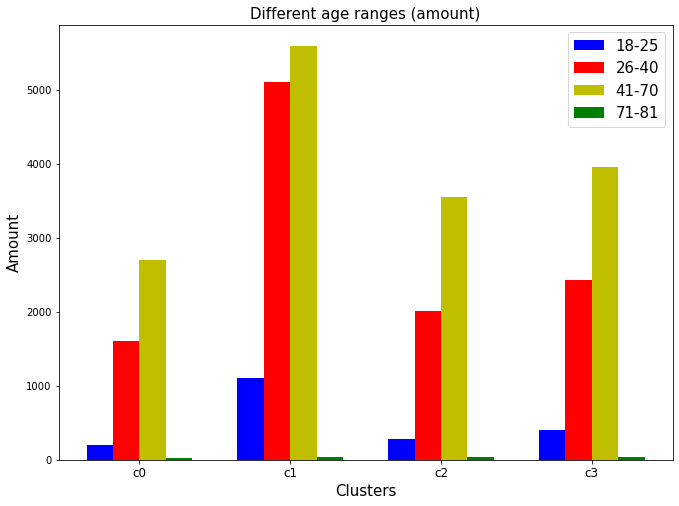

In [44]:
plt.figure(figsize=(11,8))

age_18_25 = cluster_age.iloc[0]
age_26_40 = cluster_age.iloc[1]
age_41_70 = cluster_age.iloc[2]
age_71_81 = cluster_age.iloc[3]
idx = np.arange(0,8,2)
bar_width = 0.35

plt.bar(idx - bar_width*1.5, age_18_25, color='b', width=bar_width, label='18-25')
plt.bar(idx - bar_width/2, age_26_40, color='r', width=bar_width, label='26-40')
plt.bar(idx + bar_width/2, age_41_70, color='y', width=bar_width, label='41-70')
plt.bar(idx + bar_width*1.5, age_71_81, color='g', width=bar_width, label='71-81')

plt.xticks(idx, cluster_age.columns, fontsize=12)
plt.legend(fontsize=15)
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('Amount', fontsize=15)
plt.title('Different age ranges (amount)', fontsize=15)

plt.show()

### youngest and oldest age ranges

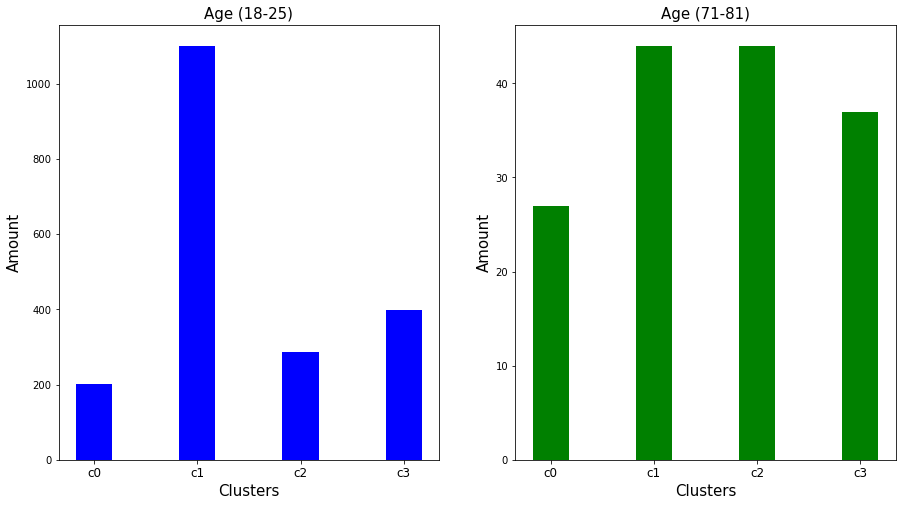

In [45]:
plt.figure(figsize=(15,8))

idx = np.arange(4)
plt.subplot(121)
plt.bar(idx, age_18_25, color='b', width=bar_width, label='Male')
plt.xticks(idx, cluster_age.columns, fontsize=12)
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('Amount', fontsize=15)
plt.title('Age (18-25)', fontsize=15)

plt.subplot(122)
plt.bar(idx, age_71_81, color='g', width=bar_width, label='Male')
plt.xticks(idx, cluster_age.columns, fontsize=12)
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('Amount', fontsize=15)
plt.title('Age (71-81)', fontsize=15)

plt.show()

### percentage

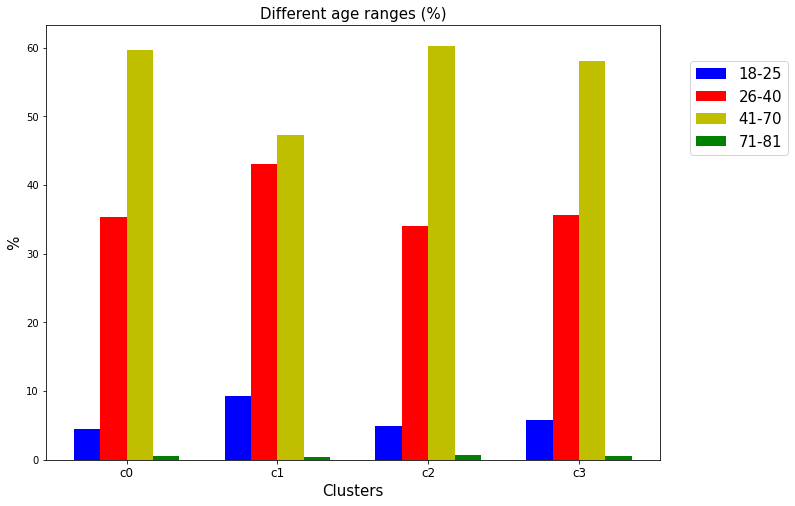

In [46]:
plt.figure(figsize=(11,8))

age_18_25_percent = cluster_age.apply(lambda x: x.iloc[0]/(x.iloc[0]+x.iloc[1]+x.iloc[2]+x.iloc[3])*100)
age_26_40_percent = cluster_age.apply(lambda x: x.iloc[1]/(x.iloc[0]+x.iloc[1]+x.iloc[2]+x.iloc[3])*100)
age_41_70_percent = cluster_age.apply(lambda x: x.iloc[2]/(x.iloc[0]+x.iloc[1]+x.iloc[2]+x.iloc[3])*100)
age_71_81_percent = cluster_age.apply(lambda x: x.iloc[3]/(x.iloc[0]+x.iloc[1]+x.iloc[2]+x.iloc[3])*100)
idx = np.arange(0,8,2)
bar_width = 0.35

plt.bar(idx - bar_width*1.5, age_18_25_percent, color='b', width=bar_width, label='18-25')
plt.bar(idx - bar_width/2, age_26_40_percent, color='r', width=bar_width, label='26-40')
plt.bar(idx + bar_width/2, age_41_70_percent, color='y', width=bar_width, label='41-70')
plt.bar(idx + bar_width*1.5, age_71_81_percent, color='g', width=bar_width, label='71-81')

plt.xticks(idx, cluster_age.columns, fontsize=12)
plt.legend(fontsize=15, loc=(1.05, 0.7))
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('%', fontsize=15)
plt.title('Different age ranges (%)', fontsize=15)

plt.show()

### CONCLUSION:
### - Cluster 0 contains the most youngest runners
### - Cluster 0 and 2 contain the most oldest runners

## 6.2 Finishing time ('Official')

### younger runners tend to run faster

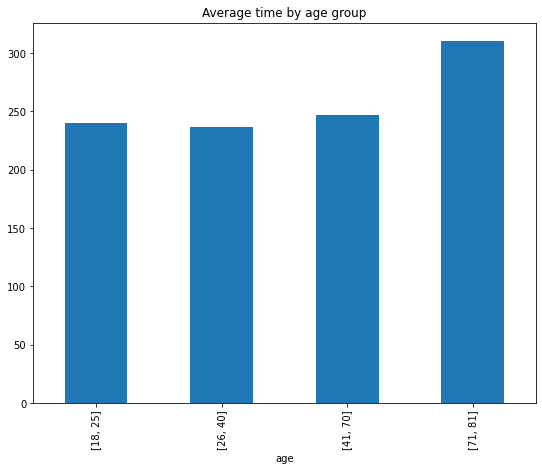

In [47]:
plt.figure(figsize=(9,7))
df3['official'].groupby(pd.cut(df3['age'], pd.IntervalIndex.from_tuples([(18, 25), (26, 40), (41, 70), (71, 81)], closed='both'))).aggregate(np.average).plot(kind="bar", title="Average time by age group")
plt.show()

### Males tend to run faster than females

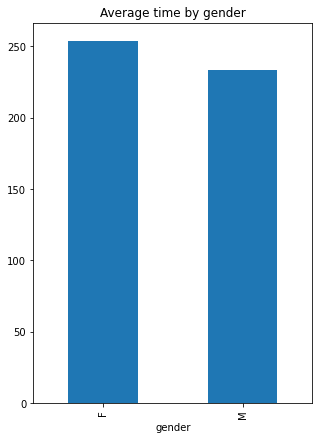

In [48]:
plt.figure(figsize=(5,7))
df3['official'].groupby(df3.gender).aggregate(np.average).plot(kind="bar", title="Average time by gender")
plt.show()

### average finishing time in each cluster

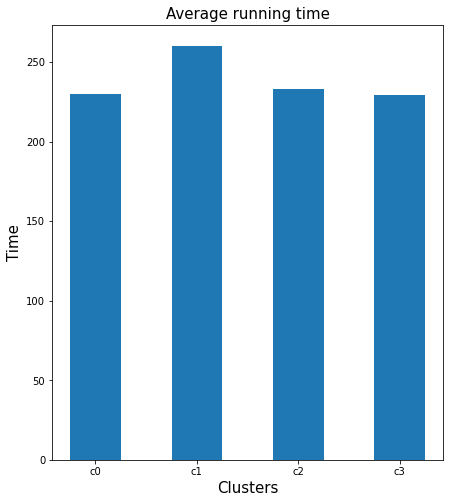

In [49]:
plt.figure(figsize=(7,8))
plt.bar([0,1,2,3],[c0.official.mean(),c1.official.mean(),c2.official.mean(),c3.official.mean()], width=0.5)

plt.xticks([0,1,2,3],['c0','c1','c2','c3'])
plt.xlabel('Clusters', fontsize=15)
plt.ylabel('Time', fontsize=15)
plt.title('Average running time', fontsize=15)


plt.show()

## CONCLUSION: cluster 0 has the highest finishing time